In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [12]:
# Set directories for training and test datasets
train_dir = '/Users/tishyakasliwal/Real_AI_SD_LD_Dataset/train/UkiyoE'  
test_dir = '/Users/tishyakasliwal/Real_AI_SD_LD_Dataset/test/UkiyoE'  

In [10]:
# Data augmentation and normalization for training
# Just normalization for validation
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Changed to 64x64
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),  # Changed to 64x64
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [9]:
import os
# Debugging: Check if the ukiyo directories exists 
print("Train directory exists:", os.path.exists(train_dir))
print("Test directory exists:", os.path.exists(test_dir))


Train directory exists: True
Test directory exists: True


In [13]:
# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
test_dataset = ImageFolder(root=test_dir, transform=test_transforms)

In [14]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)  # Increased batch size
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)   # Increased batch size

In [15]:
# Define the CNN architecture
class ArtStyleCNN(nn.Module):
    def __init__(self, num_classes=2):
        super(ArtStyleCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(256),
            nn.Dropout(0.25),  # Regularization
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(512),
            nn.Dropout(0.25),  # Regularization
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(512 * 4 * 4, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(1024, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [17]:
# Instantiate your model
model = ArtStyleCNN()

# Load the state dictionary into your model
model.load_state_dict(torch.load('final_art_style_cnn.pth'))

# Set the model to evaluation mode if you are using it for inference
model.eval()

/var/folders/2z/ssqbf1vd32x1pypcmcgd5k5m0000gn/T/ipykernel_13955/563390526.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('final_art_st

ArtStyleCNN(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.25, inplace=False)
    (12): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (13): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (14)

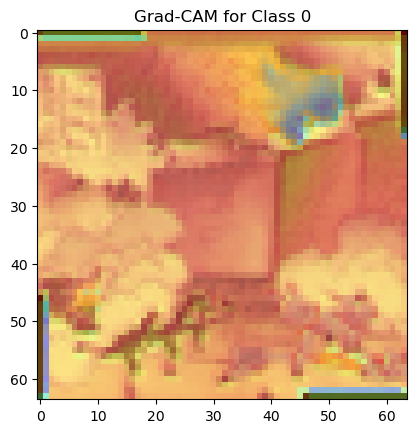

In [36]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

def grad_cam(model, input_image, target_class, target_layer):
    model.eval()
    
    # Forward pass
    activation = None
    gradients = None

    def save_activation(module, input, output):
        nonlocal activation
        activation = output.detach()

    def save_gradient(module, grad_input, grad_output):
        nonlocal gradients
        gradients = grad_output[0].detach()

    # Register hooks
    target_layer.register_forward_hook(save_activation)
    target_layer.register_backward_hook(save_gradient)
    
    # Forward and backward pass
    input_image = input_image.unsqueeze(0)  # Add batch dimension
    output = model(input_image)
    model.zero_grad()
    class_loss = output[0, target_class]
    class_loss.backward()
    
    # Grad-CAM calculations
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    for i in range(activation.shape[1]):
        activation[:, i, :, :] *= pooled_gradients[i]
    
    heatmap = torch.mean(activation, dim=1).squeeze().cpu().numpy()
    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= np.max(heatmap)  # Normalize
    
    # Convert heatmap to original image size
    heatmap = cv2.resize(heatmap, (input_image.shape[2], input_image.shape[3]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    
    # Overlay heatmap on original image
    img = input_image.squeeze().permute(1, 2, 0).cpu().numpy()
    img = img - img.min()
    img = img / img.max()
    img = np.uint8(255 * img)
    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    
    plt.imshow(overlay)
    plt.title(f"Grad-CAM for Class {target_class}")
    plt.show()

input_image, _ = train_dataset[5]  # Example image
grad_cam(model, input_image, target_class=0, target_layer=model.features[1])

/Users/tishyakasliwal/anaconda3/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:714: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x = np.array(x, subok=True, copy=copy)


ValueError: only one element tensors can be converted to Python scalars

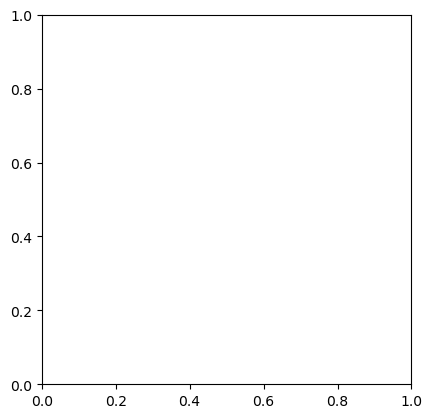

In [34]:
import matplotlib.pyplot as plt
import torch
from torchvision import transforms
from PIL import Image

# Retrieve the image and label
image = train_dataset[2]  # This will give you the 2nd sample (index 2) from the dataset

# If the image is a tensor, we need to convert it to a format suitable for displaying.
# Convert it from Tensor to PIL Image (assuming it's a Tensor in CxHxW format)
#image = transforms.ToPILImage()(image)

# Display the image using matplotlib
plt.imshow(image)
plt.title(f"Label: {label}")  # You can print the label to understand which class it belongs to
plt.axis('off')  # Hide axes
plt.show()